# Cycle-GAN

https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

Metto le cartelle generate nelle destinazioni giuste

In [26]:
import shutil
import os

# Copia per benigno (nevus)
src_dst_pairs = [
    (r"C:\projects\skcm-gen-data\dati\benigno_training",   r"C:\projects\skcm-gen-data\training\nevus"),
    (r"C:\projects\skcm-gen-data\dati\benigno_test",       r"C:\projects\skcm-gen-data\test\nevus"),
    (r"C:\projects\skcm-gen-data\dati\benigno_validation", r"C:\projects\skcm-gen-data\validation\nevus"),
]

for src, dst in src_dst_pairs:
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src, dst)
    print(f"✅ Copiata {src} → {dst}")

# Copia per melanoma
src_dst_pairs_melanoma = [
    (r"C:\projects\skcm-gen-data\dati\melanoma_training",   r"C:\projects\skcm-gen-data\training\melanoma"),
    (r"C:\projects\skcm-gen-data\dati\melanoma_test",       r"C:\projects\skcm-gen-data\test\melanoma"),
    (r"C:\projects\skcm-gen-data\dati\melanoma_validation", r"C:\projects\skcm-gen-data\validation\melanoma"),
]

for src, dst in src_dst_pairs_melanoma:
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src, dst)
    print(f"✅ Copiata {src} → {dst}")

✅ Copiata C:\projects\skcm-gen-data\dati\benigno_training → C:\projects\skcm-gen-data\training\nevus
✅ Copiata C:\projects\skcm-gen-data\dati\benigno_test → C:\projects\skcm-gen-data\test\nevus
✅ Copiata C:\projects\skcm-gen-data\dati\benigno_validation → C:\projects\skcm-gen-data\validation\nevus
✅ Copiata C:\projects\skcm-gen-data\dati\melanoma_training → C:\projects\skcm-gen-data\training\melanoma
✅ Copiata C:\projects\skcm-gen-data\dati\melanoma_test → C:\projects\skcm-gen-data\test\melanoma
✅ Copiata C:\projects\skcm-gen-data\dati\melanoma_validation → C:\projects\skcm-gen-data\validation\melanoma


In [1]:
import torch

print("CUDA disponibile:", torch.cuda.is_available())
print("Numero di GPU disponibili:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


CUDA disponibile: True
Numero di GPU disponibili: 1
GPU 0: NVIDIA RTX 500 Ada Generation Laptop GPU


In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import save_image
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import lpips
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize
from scipy.linalg import sqrtm
from torch.optim.lr_scheduler import LambdaLR
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import make_grid

#######################################
#           Global Settings           #
#######################################

# Set device for computations (GPU if available, else CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Directory settings (update these paths accordingly)
TRAIN_DIR = r"C:\projects\skcm-gen-data\training"
VAL_DIR   = r"C:\projects\skcm-gen-data\validation"

# Hyperparameters and training settings
BATCH_SIZE    = 1
LEARNING_RATE = 0.0002
LAMBDA_CYCLE  = 10       # Cycle consistency loss weight
LAMBDA_IDENTITY = 0.0    # loss weight for identity loss
NUM_EPOCHS    = 200-88     # Adjust epochs as needed
NUM_WORKERS   = 0        # Adjust based on your system

# Checkpoint file paths (for saving and loading models)
CHECKPOINT_GENERATOR_H    = r"C:\projects\skcm-gen-data\models\genh.pth.tar"
CHECKPOINT_GENERATOR_Z    = r"C:\projects\skcm-gen-data\models\genz.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = r"C:\projects\skcm-gen-data\models\disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = r"C:\projects\skcm-gen-data\models\discz.pth.tar"

CHECKPOINT_GENERATOR_H    = r"C:\projects\skcm-gen-data\models\genh_epoch88.pth.tar"
CHECKPOINT_GENERATOR_Z    = r"C:\projects\skcm-gen-data\models\genz_epoch88.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = r"C:\projects\skcm-gen-data\models\disch_epoch88.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = r"C:\projects\skcm-gen-data\models\discz_epoch88.pth.tar"

# Set to True to load existing checkpoints and to save checkpoints during training
LOAD_MODEL = True
SAVE_MODEL = True

# Albumentations transforms for image preprocessing and augmentation
transforms = A.Compose(
    [
        A.Resize(width=286, height=286),
        A.RandomCrop(256, 256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    #is_check_shapes=False,
    additional_targets={"image0": "image"},
)

#######################################
#         Helper Functions            #
#######################################

def seed_everything(seed=42):
    """
    Fix all random seeds for reproducibility.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Optionally, you can uncomment the next line to fix the seed.
# seed_everything()


def save_checkpoint(model, optimizer, filename, epoch=None):
    """
    Save model and optimizer state to a checkpoint file, including epoch number.
    """
    # print(f"=> Saving checkpoint: {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    if epoch is not None:
        checkpoint["epoch"] = epoch
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    """
    Load model and optimizer state from a checkpoint file.
    Also reset the learning rate.
    """
    print(f"=> Loading checkpoint: {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

#######################################
#         Model Architecture          #
#######################################

# Convolutional block with optional downsampling or upsampling
"""
Convolutional Block that will be used in Generator.
We initialize 2 type of convolutional blocks. The first one is a downsampling block, and the second one is the upsampling block. 
The upsampling uses ConvTranspose2d followed by InstanceNorm2d and ReLU, as described in the architecture mentioned in the paper.

"""
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_downsampling: bool = True,
                 add_activation: bool = True, **kwargs):
        super().__init__()
        layers = []
        if is_downsampling:
            layers.append(nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs))
        else:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, **kwargs))
        layers.append(nn.InstanceNorm2d(out_channels))
        if add_activation:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


# Residual block used in the generator network
class ResidualBlock(nn.Module):
    """
    The purpose of a residual block is to learn the residual mapping between
    the input and output of the block. The first ConvBlock in the sequence,
    which includes an activation function, helps in capturing and extracting
    important features from the input. The activation function introduces
    non-linearity, allowing the network to model complex relationships
    between the input and output.

    The second ConvBlock does not include an activation function.
    It mainly focuses on adjusting the dimensions (e.g., number of channels)
    of the features extracted by the first ConvBlock. The absence of an
    activation function in the second ConvBlock allows the block to learn
    the residual information. By directly adding the output of the second
    ConvBlock to the original input, the block learns to capture the
    residual features or changes needed to reach the desired output.
    """
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


# Generator network (CycleGAN style)
class Generator(nn.Module):
    def __init__(self, img_channels: int, num_features: int = 64, num_residuals: int = 6):

        """
        Generator consists of 2 layers of downsampling/encoding layer, 
        followed by 6 residual blocks for 128 × 128 training images 
        and then 3 upsampling/decoding layer. 
        
        The network with 6 residual blocks can be written as: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
                
        super().__init__()
        # Initial convolutional block
        self.initial_layer = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        # Downsampling layers
        self.downsampling_layers = nn.Sequential(
            ConvolutionalBlock(num_features, num_features * 2, is_downsampling=True,
                               kernel_size=3, stride=2, padding=1),
            ConvolutionalBlock(num_features * 2, num_features * 4, is_downsampling=True,
                               kernel_size=3, stride=2, padding=1),
        )
        # Residual layers
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        # Upsampling layers
        self.upsampling_layers = nn.Sequential(
            ConvolutionalBlock(num_features * 4, num_features * 2, is_downsampling=False,
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvolutionalBlock(num_features * 2, num_features, is_downsampling=False,
                               kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        # Last convolutional layer that outputs the image
        self.last_layer = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.downsampling_layers(x)
        x = self.residual_layers(x)
        x = self.upsampling_layers(x)
        return torch.tanh(self.last_layer(x))


# Discriminator network (PatchGAN style)
class Discriminator(nn.Module):
    """
    We will use Convolution-InstanceNorm-LeakyReLU block as mentioned in the paper.
    Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2. 
    Discriminator architecture is: C64-C128-C256-C512. 
    After the last layer, we apply a convolution to produce a 1-dimensional output. We use leaky ReLUs with a slope of 0.2.
    """
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )
        layers = []
        in_channels_curr = features[0]
        for feature in features[1:]:
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels_curr, feature, kernel_size=4, 
                          stride=1 if feature == features[-1] else 2, 
                          padding=1, padding_mode="reflect"),
                nn.InstanceNorm2d(feature),
                nn.LeakyReLU(0.2, inplace=True),
            ))
            in_channels_curr = feature
        layers.append(nn.Conv2d(in_channels_curr, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return torch.sigmoid(self.model(x)) # we feed the model output into a sigmoid function to make a 1/0 label
    # This discriminator class will be used to create 2 objects, both representing discriminator for fake zebras, and discriminator for fake horses.


#######################################
#         Custom Dataset              #
#######################################

class MelanomaNevusDataset(Dataset):
    """
    Custom dataset for loading melanoma and nevus images.
    Expects two directories: one for nevus images and one for melanoma images.
    """
    def __init__(self, root_nevus, root_melanoma, transform=None):
        self.root_nevus = root_nevus
        self.root_melanoma = root_melanoma
        self.transform = transform
        self.nevus_images = os.listdir(root_nevus)
        self.melanoma_images = os.listdir(root_melanoma)

    def __len__(self):
        return max(len(self.nevus_images), len(self.melanoma_images))

    def __getitem__(self, index):
        # Use modulo indexing in case one folder has fewer images than the other
        nevus_img_name = self.nevus_images[index % len(self.nevus_images)]
        melanoma_img_name = self.melanoma_images[index % len(self.melanoma_images)]
        nevus_path = os.path.join(self.root_nevus, nevus_img_name)
        melanoma_path = os.path.join(self.root_melanoma, melanoma_img_name)
        nevus_img = Image.open(nevus_path).convert("RGB")
        melanoma_img = Image.open(melanoma_path).convert("RGB")
        
        # Apply transforms if provided
        if self.transform:
            nevus_img = self.transform(image=np.array(nevus_img))["image"]
            melanoma_img = self.transform(image=np.array(melanoma_img))["image"]
        return nevus_img, melanoma_img


#######################################
#         Training and Testing        #
#######################################

def train_fn(disc_M, disc_N, gen_N, gen_M, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, epoch):
    """
    Train both generators and discriminators for one epoch.
    - disc_M: Discriminator for melanoma images.
    - disc_N: Discriminator for nevus images.
    - gen_M: Generator that converts nevus to melanoma.
    - gen_N: Generator that converts melanoma to nevus.

    The objective of the training process is to develop a generator G: X -> Y that produces 
    a distribution of images from G(X) that are similar enough to the distribution Y, 
    so that they cannot be distinguished from the real images using an adversarial loss.
    We will train CycleGAN to be able to map X to Y using generator G, and the inverse, from Y to X with generator F. 
    With two generators, we also has 2 discriminator for both X and Y, named Dx and Dy.

    """
    running_d_loss = 0
    running_cycle_loss = 0
    running_G_loss = 0
    running_tot_loss = 0

    M_reals, M_fakes = 0, 0 
    # variables that will be used to accumulate the average values of the outputs from the melanoma discriminator disc_M for real and fake melanoma images.
    # These variables are primarily used to track the discriminator’s performance and can be helpful in monitoring the training progress.
    loop = tqdm(loader, leave=True)
    
    for idx, (nevus, melanoma) in enumerate(loop):
        nevus, melanoma = nevus.to(DEVICE), melanoma.to(DEVICE)
        
        # ---------------------------
        # Train Discriminators
        # ---------------------------
        """
        The loss is determined by using the mean squared error (MSE) between the discriminator 
        output and the real label (1 or 0) depending on whether it considered real or fake. Also note that 
        the total loss in the discriminator is computed by taking the mean of both the horse and zebra discriminator losses.

        Following that, we proceed to define the generators. We also establish three types of losses that were previously discussed: 
        adversarial loss, cycle loss, and identity loss. These losses are then summed up by combining and assigning weights to each of them.
        """
        with torch.amp.autocast('cuda'):
            # Generate fake melanoma from nevus
            fake_melanoma = gen_M(nevus)
            D_M_real = disc_M(melanoma)
            D_M_fake = disc_M(fake_melanoma.detach())
            M_reals += D_M_real.mean().item()
            M_fakes += D_M_fake.mean().item()
            D_M_real_loss = mse(D_M_real, torch.ones_like(D_M_real))
            D_M_fake_loss = mse(D_M_fake, torch.zeros_like(D_M_fake))
            D_M_loss = D_M_real_loss + D_M_fake_loss
            
            # Generate fake nevus from melanoma
            fake_nevus = gen_N(melanoma)
            D_N_real = disc_N(nevus)
            D_N_fake = disc_N(fake_nevus.detach())
            D_N_real_loss = mse(D_N_real, torch.ones_like(D_N_real))
            D_N_fake_loss = mse(D_N_fake, torch.zeros_like(D_N_fake))
            D_N_loss = D_N_real_loss + D_N_fake_loss
            
            # Total discriminator loss (average over both domains)
            D_loss = (D_M_loss + D_N_loss) / 2
            running_d_loss += D_loss.item()

        #print(f"D_loss: {D_loss}")
        
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # ---------------------------
        # Train Generators
        # ---------------------------
        with torch.amp.autocast('cuda'):
            # Adversarial losses: try to fool discriminators
            loss_G_M = mse(disc_M(fake_melanoma), torch.ones_like(D_M_fake))
            loss_G_N = mse(disc_N(fake_nevus), torch.ones_like(D_N_fake))
            loss_G_MN = loss_G_M + loss_G_N
            
            # Cycle consistency: translating back should result in the original image
            cycle_nevus = gen_N(fake_melanoma)
            cycle_melanoma = gen_M(fake_nevus)
            cycle_nevus_loss = l1(nevus, cycle_nevus)
            cycle_melanoma_loss = l1(melanoma, cycle_melanoma)
            cycle_loss = cycle_nevus_loss + cycle_melanoma_loss

            # Identity loss
            #identity_nevus = gen_Z(nevus)
            #identity_melanoma = gen_H(melanoma)
            #identity_loss_nevus = l1(nevus, identity_nevus) 
            #identity_loss_melanoma = l1(melanoma, identity_melanoma)
            #G_loss += 0.5 * LAMBDA_CYCLE * identity_loss

            
            # Total generator loss includes adversarial and cycle losses
            G_loss = (
                loss_G_M + loss_G_N + cycle_nevus_loss * LAMBDA_CYCLE + cycle_melanoma_loss * LAMBDA_CYCLE
                # + identity_loss_nevus*LAMBDA_IDENTITY + identity_loss_melanoma*LAMBDA_IDENTITY
            )

            total_loss = G_loss + D_loss

            
            running_cycle_loss += cycle_loss.item()
            running_G_loss += loss_G_MN.item()
            running_tot_loss += total_loss.item()

        #print(f"Generator_loss:{loss_G_MN}") 
        #print(f"Cycle_loss:{cycle_loss}")   
        #print(f"Total_G_loss: {G_loss}")

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        # Salva i primi 3 esempi di fake_melanoma e fake_nevus con i corrispondenti input
        if idx < 3:
            epoch_dir = f"C:/projects/skcm-gen-data/outputs/epoch_{epoch+1:03d}"
            os.makedirs(epoch_dir, exist_ok=True)

            save_image(nevus * 0.5 + 0.5, os.path.join(epoch_dir, f"input_nevus_{idx}.png"))
            save_image(fake_melanoma * 0.5 + 0.5, os.path.join(epoch_dir, f"fake_melanoma_{idx}.png"))
            save_image(melanoma * 0.5 + 0.5, os.path.join(epoch_dir, f"input_melanoma_{idx}.png"))
            save_image(fake_nevus * 0.5 + 0.5, os.path.join(epoch_dir, f"fake_nevus_{idx}.png"))

        loop.set_postfix(M_real=M_reals / (idx + 1), M_fake=M_fakes / (idx + 1))
    
    print(f"Loss_Discriminator: {running_d_loss / len(loader)}")
    print(f"Cycle_Loss: {running_cycle_loss / len(loader)}")
    print(f"Loss_Generator: {running_G_loss / len(loader)}")
    print(f"Total_Loss: {running_tot_loss / len(loader)}")


def test_fn(gen_H, gen_Z, val_loader, num_samples=50):
    """
    Test the CycleGAN model on the validation dataset.
    - gen_H: Generator that converts nevus to melanoma.
    - gen_Z: Generator that converts melanoma to nevus.
    """
    gen_H.eval()
    gen_Z.eval()
    sample_count = 0
    with torch.no_grad():
        for idx, (nevus, melanoma) in enumerate(val_loader):
            nevus, melanoma = nevus.to(DEVICE), melanoma.to(DEVICE)
            fake_melanoma = gen_H(nevus)
            fake_nevus = gen_Z(melanoma)
            save_image(nevus * 0.5 + 0.5, f"C:/projects/skcm-gen-data/outputs/test_nevus_{idx}.png")
            save_image(melanoma * 0.5 + 0.5, f"C:/projects/skcm-gen-data/outputs/test_melanoma_{idx}.png")
            save_image(fake_melanoma * 0.5 + 0.5, f"C:/projects/skcm-gen-data/outputs/fake_melanoma_{idx}.png")
            save_image(fake_nevus * 0.5 + 0.5, f"C:/projects/skcm-gen-data/outputs/fake_nevus_{idx}.png")
            sample_count += 1
            if sample_count >= num_samples:
                break
    # Return to training mode after testing
    gen_H.train()
    gen_Z.train()


from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F


def calculate_fid(real_images, fake_images, device):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = nn.Identity()
    model.eval()

    def get_features(images):
        with torch.no_grad():
            images_resized = F.interpolate(images, size=(299, 299), mode='bilinear')
            return model(images_resized).cpu().numpy()

    real_feats = get_features(real_images)
    fake_feats = get_features(fake_images)

    mu1, sigma1 = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)
    mu2, sigma2 = fake_feats.mean(axis=0), np.cov(fake_feats, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


#######################################
#              Main Flow              #
#######################################

"""
Adam optimizers (opt_disc and opt_gen) are used for both the generator and discriminator networks. 
The optimizers are passed the parameters of the corresponding networks, learning rate (LEARNING_RATE), and betas values.

GradScaler objects (g_scaler and d_scaler) are created using torch.cuda.amp.GradScaler() 
to enable mixed-precision training with automatic scaling of gradients. 
These scalers are used during training to handle gradient calculations and adjustments.

The training loop starts, iterating over the specified number of epochs (NUM_EPOCHS). Within each epoch, 
the train_fn() function is called to perform the training process. 
The discriminator and generator networks, along with other necessary arguments, are passed to this function.
"""

def main():
    # Instantiate discriminators and generators.
    # Here, we define:
    # - gen_H: Generator converting nevus to melanoma.
    # - gen_Z: Generator converting melanoma to nevus.
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    
    # Define optimizers for generators and discriminators
    opt_disc = optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()),
                            lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(list(gen_H.parameters()) + list(gen_Z.parameters()),
                           lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    

    def lambda_rule(epoch):
        lr_start_decay = 100  # oppure un altro valore se preferisci
        if epoch < lr_start_decay:
            return 1.0
        else:
            return 1.0 - float(epoch - lr_start_decay) / float(NUM_EPOCHS - lr_start_decay + 1)

    scheduler_gen = LambdaLR(opt_gen, lr_lambda=lambda_rule)
    scheduler_disc = LambdaLR(opt_disc, lr_lambda=lambda_rule)



    # Loss functions: L1 for cycle consistency and MSE for adversarial loss
    L1_loss = nn.L1Loss()
    mse_loss = nn.MSELoss()
    
    # Load checkpoints if specified
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GENERATOR_H, gen_H, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_GENERATOR_Z, gen_Z, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISCRIMINATOR_H, disc_H, opt_disc, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISCRIMINATOR_Z, disc_Z, opt_disc, LEARNING_RATE)
    
    # Create dataset objects for training and validation
    train_dataset = MelanomaNevusDataset(
        root_nevus=os.path.join(TRAIN_DIR, "nevus"),
        root_melanoma=os.path.join(TRAIN_DIR, "melanoma"),
        transform=transforms,
    )
    val_dataset = MelanomaNevusDataset(
        root_nevus=os.path.join(VAL_DIR, "nevus"),
        root_melanoma=os.path.join(VAL_DIR, "melanoma"),
        transform=transforms,
    )
    
    # Create DataLoader objects for training and validation
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    
    # GradScaler for mixed precision training
    g_scaler = torch.amp.GradScaler('cuda')
    d_scaler = torch.amp.GradScaler('cuda')
    
    # ---------------------------
    # Training Phase
    # ---------------------------
    
    fid_log = []

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        train_fn(disc_H, disc_Z, gen_Z, gen_H, train_loader, opt_disc, opt_gen, L1_loss, mse_loss, d_scaler, g_scaler, epoch=epoch)
        scheduler_gen.step()
        scheduler_disc.step()
        # print(f"🔄 Learning rate aggiornato: {scheduler_gen.get_last_lr()[0]:.6f}")

        # if (epoch + 1) % 10 == 0:
        #     from torchvision.io import read_image

        #     # Percorso all’epoca corrente
        #     epoch_dir = f"C:/projects/skcm-gen-data/outputs/epoch_{epoch+1:03d}"

        #     real_img_path = os.path.join(epoch_dir, "input_nevus.png")
        #     fake_img_path = os.path.join(epoch_dir, "fake_melanoma.png")

        #     if os.path.exists(real_img_path) and os.path.exists(fake_img_path):
        #         real = read_image(real_img_path).unsqueeze(0).float().to(DEVICE) / 255
        #         fake = read_image(fake_img_path).unsqueeze(0).float().to(DEVICE) / 255

        #         fid_score = calculate_fid(real, fake, DEVICE)
        #         fid_log.append({"epoch": epoch + 1, "fid": fid_score})
        #         print(f"📉 FID (nevus → fake_melanoma) @ epoch {epoch+1}: {fid_score:.2f}")

                


        if SAVE_MODEL:

            # Sovrascrivi il checkpoint principale per resume semplice
            save_checkpoint(gen_H, opt_gen, CHECKPOINT_GENERATOR_H, epoch=epoch+1)
            save_checkpoint(gen_Z, opt_gen, CHECKPOINT_GENERATOR_Z, epoch=epoch+1)
            save_checkpoint(disc_H, opt_disc, CHECKPOINT_DISCRIMINATOR_H, epoch=epoch+1)
            save_checkpoint(disc_Z, opt_disc, CHECKPOINT_DISCRIMINATOR_Z, epoch=epoch+1)

            save_checkpoint(gen_H, opt_gen, CHECKPOINT_GENERATOR_H.replace(".pth.tar", f"_epoch{epoch+1}.pth.tar"), epoch=epoch+1)
            save_checkpoint(gen_Z, opt_gen, CHECKPOINT_GENERATOR_Z.replace(".pth.tar", f"_epoch{epoch+1}.pth.tar"), epoch=epoch+1)
            save_checkpoint(disc_H, opt_disc, CHECKPOINT_DISCRIMINATOR_H.replace(".pth.tar", f"_epoch{epoch+1}.pth.tar"), epoch=epoch+1)
            save_checkpoint(disc_Z, opt_disc, CHECKPOINT_DISCRIMINATOR_Z.replace(".pth.tar", f"_epoch{epoch+1}.pth.tar"), epoch=epoch+1)



    fid_df = pd.DataFrame(fid_log)
    #fid_df.to_csv("C:/projects/skcm-gen-data/outputs/fid_log.csv", index=False)
    #print("✅ Log FID salvato in fid_log.csv")


    
    # ---------------------------
    # Testing Phase
    # ---------------------------
    test_fn(gen_H, gen_Z, val_loader, num_samples=50)


if __name__ == "__main__":
    main()


c:\projects\skcm-gen\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\projects\skcm-gen\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
=> Loading checkpoint: C:\projects\skcm-gen-data\models\genh_epoch88.pth.tar
=> Loading checkpoint: C:\projects\skcm-gen-data\models\genz_epoch88.pth.tar
=> Loading checkpoint: C:\projects\skcm-gen-data\models\disch_epoch88.pth.tar
=> Loading checkpoint: C:\projects\skcm-gen-data\models\discz_epoch88.pth.tar
Epoch [1/112]


 53%|█████▎    | 800/1500 [10:34<09:15,  1.26it/s, M_fake=0.287, M_real=0.699]


KeyboardInterrupt: 

Inferenza (su immagini in test)

In [ ]:
import os
import torch
from PIL import Image
from torchvision.utils import save_image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn



# === CONFIG ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_GEN_H = r"C:\projects\skcm-gen-data\models\genh_epoch200.pth.tar"
CHECKPOINT_GEN_Z = r"C:\projects\skcm-gen-data\models\genz_epoch200.pth.tar"

INPUT_DIR_NEVUS = r"C:\projects\skcm-gen-data\test\nevus"
INPUT_DIR_MELANOMA = r"C:\projects\skcm-gen-data\test\melanoma"


OUTPUT_DIR_FAKE_MELANOMA = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"
OUTPUT_DIR_FAKE_NEVUS = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"



os.makedirs(OUTPUT_DIR_FAKE_MELANOMA, exist_ok=True)
os.makedirs(OUTPUT_DIR_FAKE_NEVUS, exist_ok=True)

# === TRANSFORM ===
transform = A.Compose([
    A.Resize(286, 286),
    A.CenterCrop(256, 256),
    A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255),
    ToTensorV2(),
])

# === MODEL LOADING ===
def load_generator(checkpoint_path):
    model = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

gen_H = load_generator(CHECKPOINT_GEN_H)  # nevus → melanoma
gen_Z = load_generator(CHECKPOINT_GEN_Z)  # melanoma → nevus

# === INFERENZA ===
def run_inference(input_dir, output_dir, generator):
    files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))]
    for fname in files:
        img_path = os.path.join(input_dir, fname)
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)
        image_tensor = transform(image=image_np)["image"].unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            fake_img = generator(image_tensor)
        output_path = os.path.join(output_dir, fname)
        save_image(fake_img * 0.5 + 0.5, output_path)

    print(f"✅ Salvate {len(files)} immagini in: {output_dir}")

# === ESECUZIONE ===
run_inference(INPUT_DIR_NEVUS, OUTPUT_DIR_FAKE_MELANOMA, gen_H)
run_inference(INPUT_DIR_MELANOMA, OUTPUT_DIR_FAKE_NEVUS, gen_Z)


✅ Salvate 300 immagini in: C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma
✅ Salvate 300 immagini in: C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus


Comparison grid (neo reale -> melanoma generato)

In [ ]:
import os
from PIL import Image
from torchvision.utils import save_image, make_grid
import torch
import torchvision.transforms as T

# === Percorsi ===
ORIGINAL_DIR = r"C:\projects\skcm-gen-data\test\nevus"
GENERATED_DIR = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"
OUTPUT_GRID_DIR = r"C:\projects\skcm-gen-data\confronti_realneo_fakemel"


os.makedirs(OUTPUT_GRID_DIR, exist_ok=True)

# === Trasformazioni ===
to_tensor = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# === Funzione ===
def generate_comparison_grid(original_dir, generated_dir, output_dir):
    files = [f for f in os.listdir(original_dir) if f.lower().endswith(('.jpg', '.png'))]
    for fname in files:
        orig_path = os.path.join(original_dir, fname)
        gen_path = os.path.join(generated_dir, fname)

        if not os.path.exists(gen_path):
            continue

        # Carica immagini e converti in tensori
        orig = to_tensor(Image.open(orig_path).convert("RGB"))
        gen = to_tensor(Image.open(gen_path).convert("RGB"))

        # Crea griglia: [originale | generata]
        grid = make_grid([orig, gen], nrow=2)
        save_image(grid, os.path.join(output_dir, f"grid_{fname}"))

    print(f"✅ Confronti salvati in: {output_dir}")

# === ESECUZIONE ===
generate_comparison_grid(ORIGINAL_DIR, GENERATED_DIR, OUTPUT_GRID_DIR)


✅ Confronti salvati in: C:\projects\skcm-gen-data\confronti


Comparison grid (real melanoma -> fake neo)

In [ ]:
import os
from PIL import Image
from torchvision.utils import save_image, make_grid
import torch
import torchvision.transforms as T

# === Percorsi ===
ORIGINAL_DIR = r"C:\projects\skcm-gen-data\test\melanoma"
GENERATED_DIR = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"
OUTPUT_GRID_DIR = r"C:\projects\skcm-gen-data\confronti_realmel_fakeneo"


os.makedirs(OUTPUT_GRID_DIR, exist_ok=True)

# === Trasformazioni ===
to_tensor = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# === Funzione ===
def generate_comparison_grid(original_dir, generated_dir, output_dir):
    files = [f for f in os.listdir(original_dir) if f.lower().endswith(('.jpg', '.png'))]
    for fname in files:
        orig_path = os.path.join(original_dir, fname)
        gen_path = os.path.join(generated_dir, fname)

        if not os.path.exists(gen_path):
            continue

        # Carica immagini e converti in tensori
        orig = to_tensor(Image.open(orig_path).convert("RGB"))
        gen = to_tensor(Image.open(gen_path).convert("RGB"))

        # Crea griglia: [originale | generata]
        grid = make_grid([orig, gen], nrow=2)
        save_image(grid, os.path.join(output_dir, f"grid_{fname}"))

    print(f"✅ Confronti salvati in: {output_dir}")

# === ESECUZIONE ===
generate_comparison_grid(ORIGINAL_DIR, GENERATED_DIR, OUTPUT_GRID_DIR)

Salvataggio metriche training da plottare in file.csv: M_fake, M_real, Loss

In [ ]:
import re
import pandas as pd

logfile = "C:/projects/skcm-gen/train_output.txt"  # Copiare e incollare l'output della CycleGAN qui

with open(logfile, "r") as f:
    lines = f.readlines()

data = []
current = {}

for line in lines:
    if match := re.match(r"Epoch \[(\d+)/\d+\]", line):
        if current:
            data.append(current)
        current = {"Epoch": int(match.group(1))}

    if "M_fake=" in line and "M_real=" in line:
        m = re.search(r"M_fake=(\d+\.\d+)", line)
        r = re.search(r"M_real=(\d+\.\d+)", line)
        current["M_fake"] = float(m.group(1)) if m else None
        current["M_real"] = float(r.group(1)) if r else None

    if "Loss_Discriminator" in line:
        current["Loss_Discriminator"] = float(line.strip().split(": ")[1])

    if "Cycle_Loss" in line:
        current["Cycle_Loss"] = float(line.strip().split(": ")[1])

    if "Loss_Generator" in line:
        current["Loss_Generator"] = float(line.strip().split(": ")[1])

    if "Total_Loss" in line:
        current["Total_Loss"] = float(line.strip().split(": ")[1])

if current:
    data.append(current)

df = pd.DataFrame(data)
df.to_csv("C:/projects/skcm-gen-data/training_log_from_txt.csv", index=False)


Calcolo FID: è necessario che le immagini reali siano della stessa dimensione

Melanoma

In [ ]:
import os
from PIL import Image
import shutil

src_dir = r"C:\projects\skcm-gen-data\test\melanoma"
dst_dir = r"C:\projects\skcm-gen-data\test_melanoma_FID_256"

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    if fname.lower().endswith(('.jpg', '.png')):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)
        img = Image.open(src_path).convert("RGB")
        img_resized = img.resize((256, 256), Image.LANCZOS)
        img_resized.save(dst_path)

print(f"✅ Copiate e ridimensionate {len(os.listdir(dst_dir))} immagini in {dst_dir}")

✅ Copiate e ridimensionate 300 immagini in C:\projects\skcm-gen-data\test_melanoma_FID_256


In [ ]:
!python -m pytorch_fid  "C:\projects\skcm-gen-data\test_melanoma_FID_256" "C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"

FID:  105.64954746632054



100%|██████████| 6/6 [00:20<00:00,  3.43s/it]

100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


Nevus

In [ ]:
import os
from PIL import Image
import shutil

src_dir = r"C:\projects\skcm-gen-data\test\nevus"
dst_dir = r"C:\projects\skcm-gen-data\test_nevus_FID_256"

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    if fname.lower().endswith(('.jpg', '.png')):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)
        img = Image.open(src_path).convert("RGB")
        img_resized = img.resize((256, 256), Image.LANCZOS)
        img_resized.save(dst_path)

print(f"✅ Copiate e ridimensionate {len(os.listdir(dst_dir))} immagini in {dst_dir}")

In [ ]:
!python -m pytorch_fid  "C:\projects\skcm-gen-data\test_nevus_FID_256" "C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"

Calcolo Cosine Resnet Similarity

Melanoma

c:\projects\skcm-gen\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\skcm-gen\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 300/300 [00:03<00:00, 78.54it/s]



Cosine ResNet Distance (CRD): 0.6345
Performing PCA...


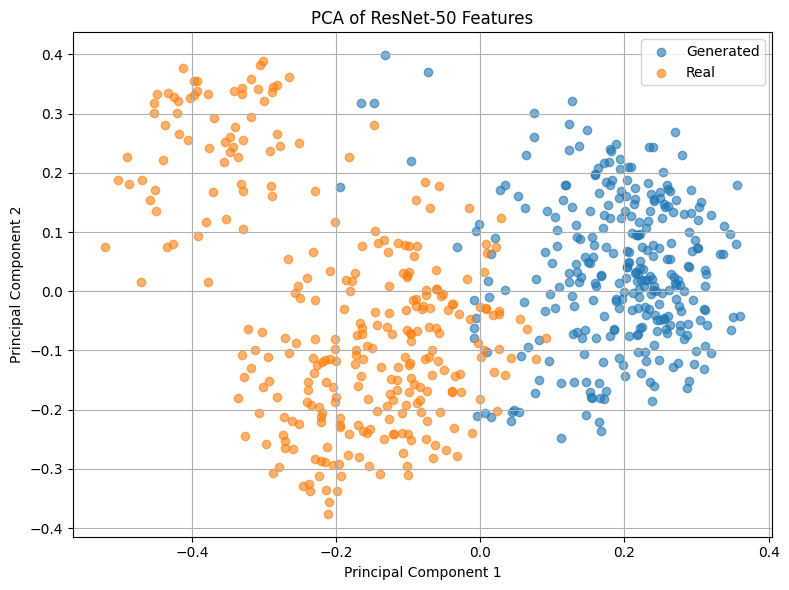

In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === CONFIG ===
gen_path = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"
real_path = r"C:\projects\skcm-gen-data\test\melanoma"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL ===
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # remove classifier
resnet50.eval().to(device)

# === PREPROCESS ===
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# === LOAD IMAGES ===
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img_path = os.path.join(folder, filename)
                image = Image.open(img_path).convert('RGB')
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# === EXTRACT FEATURES ===
def extract_features(images, model, device):
    features = []
    with torch.no_grad():
        for img in tqdm(images, desc="Extracting features"):
            tensor = preprocess(img).unsqueeze(0).to(device)
            feat = model(tensor).squeeze().cpu()  # [2048]
            feat = torch.nn.functional.normalize(feat, dim=0)
            features.append(feat)
    return torch.stack(features)  # [N, 2048]

# Load images
generated_imgs = load_images_from_folder(gen_path)
real_imgs = load_images_from_folder(real_path)

# Extract features
gen_feats = extract_features(generated_imgs, resnet50, device)
real_feats = extract_features(real_imgs, resnet50, device)

# Step 1: ResNet-50 features (normalized)
# gen_feats = [N, 2048], real_feats = [M, 2048]

# Step 2: Pairwise cosine similarities between the N generated features and the M real features
similarity_matrix = gen_feats @ real_feats.T  # [N, M]

# Step 3: Inner mean (over real samples for each generated)
mean_sim_per_generated = similarity_matrix.mean(dim=1)  # shape [N]
# This gives the average similarity of each generated sample to all real samples

# Step 4: Outer mean (over generated samples)
crd = mean_sim_per_generated.mean().item()
# This gives the final CRD value
# .item() extracts the Python float scalar from the PyTorch tensor


print(f"\nCosine ResNet Distance (CRD): {crd:.4f}")

# === PCA VISUALIZATION ===
print("Performing PCA...")
all_feats = torch.cat([gen_feats, real_feats], dim=0).numpy()
labels = ['Generated'] * len(gen_feats) + ['Real'] * len(real_feats)

# Reduce to 2D
pca = PCA(n_components=2)
feats_2d = pca.fit_transform(all_feats)

# Plot
plt.figure(figsize=(8, 6))
for label in ['Generated', 'Real']:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(feats_2d[idxs, 0], feats_2d[idxs, 1], label=label, alpha=0.6)

plt.title("PCA of ResNet-50 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Nevus

In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === CONFIG ===
gen_path = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"
real_path = r"C:\projects\skcm-gen-data\test\nevus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL ===
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # remove classifier
resnet50.eval().to(device)

# === PREPROCESS ===
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# === LOAD IMAGES ===
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img_path = os.path.join(folder, filename)
                image = Image.open(img_path).convert('RGB')
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# === EXTRACT FEATURES ===
def extract_features(images, model, device):
    features = []
    with torch.no_grad():
        for img in tqdm(images, desc="Extracting features"):
            tensor = preprocess(img).unsqueeze(0).to(device)
            feat = model(tensor).squeeze().cpu()  # [2048]
            feat = torch.nn.functional.normalize(feat, dim=0)
            features.append(feat)
    return torch.stack(features)  # [N, 2048]

# Load images
generated_imgs = load_images_from_folder(gen_path)
real_imgs = load_images_from_folder(real_path)

# Extract features
gen_feats = extract_features(generated_imgs, resnet50, device)
real_feats = extract_features(real_imgs, resnet50, device)

# Step 1: ResNet-50 features (normalized)
# gen_feats = [N, 2048], real_feats = [M, 2048]

# Step 2: Pairwise cosine similarities between the N generated features and the M real features
similarity_matrix = gen_feats @ real_feats.T  # [N, M]

# Step 3: Inner mean (over real samples for each generated)
mean_sim_per_generated = similarity_matrix.mean(dim=1)  # shape [N]
# This gives the average similarity of each generated sample to all real samples

# Step 4: Outer mean (over generated samples)
crd = mean_sim_per_generated.mean().item()
# This gives the final CRD value
# .item() extracts the Python float scalar from the PyTorch tensor


print(f"\nCosine ResNet Distance (CRD): {crd:.4f}")

# === PCA VISUALIZATION ===
print("Performing PCA...")
all_feats = torch.cat([gen_feats, real_feats], dim=0).numpy()
labels = ['Generated'] * len(gen_feats) + ['Real'] * len(real_feats)

# Reduce to 2D
pca = PCA(n_components=2)
feats_2d = pca.fit_transform(all_feats)

# Plot
plt.figure(figsize=(8, 6))
for label in ['Generated', 'Real']:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(feats_2d[idxs, 0], feats_2d[idxs, 1], label=label, alpha=0.6)

plt.title("PCA of ResNet-50 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pair plot PCA

Melanoma

In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === CONFIG ===
gen_path = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"
real_path = r"C:\projects\skcm-gen-data\test\melanoma"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL: ResNet-50 ===
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove final FC layer
resnet.eval().to(device)

# === PREPROCESS for ResNet-50 (224x224) ===
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# === LOAD IMAGES ===
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img_path = os.path.join(folder, filename)
                image = Image.open(img_path).convert('RGB')
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# === EXTRACT FEATURES ===
def extract_features(images, model, device):
    features = []
    with torch.no_grad():
        for img in tqdm(images, desc="Extracting ResNet features"):
            tensor = preprocess(img).unsqueeze(0).to(device)
            feat = model(tensor).squeeze().cpu()  # shape: [2048]
            feat = torch.nn.functional.normalize(feat, dim=0)
            features.append(feat)
    return torch.stack(features)  # shape: [N, 2048]

# === LOAD IMAGES ===
generated_imgs = load_images_from_folder(gen_path)
real_imgs = load_images_from_folder(real_path)

# === FEATURE EXTRACTION ===
gen_feats = extract_features(generated_imgs, resnet, device)
real_feats = extract_features(real_imgs, resnet, device)

# === PCA REDUCTION TO 3 COMPONENTS ===
all_feats = torch.cat([gen_feats, real_feats], dim=0).numpy()
labels = ['Generated'] * len(gen_feats) + ['Real'] * len(real_feats)

pca = PCA(n_components=3)
feats_pca = pca.fit_transform(all_feats)

# === PREPARE DATAFRAME FOR PLOTTING ===
df = pd.DataFrame(feats_pca, columns=["PC1", "PC2", "PC3"])
df['Label'] = labels

# === PAIR PLOT ===
sns.set(style="whitegrid", palette="muted")
pairplot = sns.pairplot(df, hue="Label", diag_kind="kde", corner=True,
                        plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'})
pairplot.fig.suptitle("Pair Plot of First 3 PCA Components (ResNet-50 Features)", y=1.02)
plt.show()


PRDC (Precision, Recall, Density, Coverage)

In [ ]:
import numpy as np
from prdc import compute_prdc


metrics = compute_prdc(real_features=real_feats,
                       fake_features=gen_feats,
                       nearest_k=5)

print(metrics)

Nevus

c:\projects\skcm-gen\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting ResNet features: 100%|██████████| 300/300 [00:12<00:00, 24.21it/s]


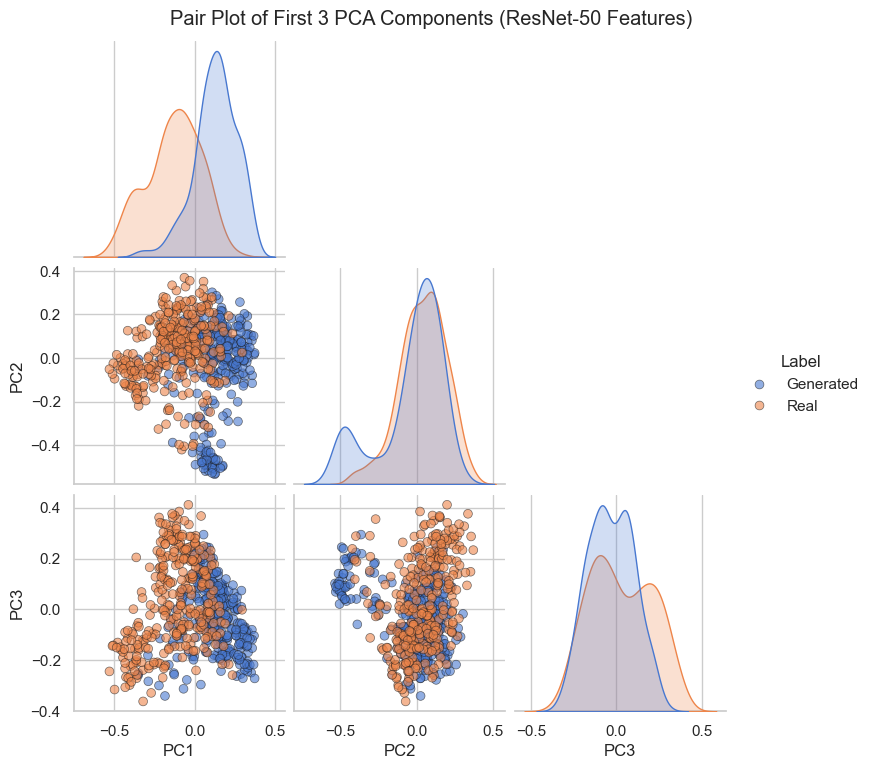

In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === CONFIG ===
gen_path = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"
real_path = r"C:\projects\skcm-gen-data\test\nevus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL: ResNet-50 ===
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove final FC layer
resnet.eval().to(device)

# === PREPROCESS for ResNet-50 (224x224) ===
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# === LOAD IMAGES ===
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img_path = os.path.join(folder, filename)
                image = Image.open(img_path).convert('RGB')
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# === EXTRACT FEATURES ===
def extract_features(images, model, device):
    features = []
    with torch.no_grad():
        for img in tqdm(images, desc="Extracting ResNet features"):
            tensor = preprocess(img).unsqueeze(0).to(device)
            feat = model(tensor).squeeze().cpu()  # shape: [2048]
            feat = torch.nn.functional.normalize(feat, dim=0)
            features.append(feat)
    return torch.stack(features)  # shape: [N, 2048]

# === LOAD IMAGES ===
generated_imgs = load_images_from_folder(gen_path)
real_imgs = load_images_from_folder(real_path)

# === FEATURE EXTRACTION ===
gen_feats = extract_features(generated_imgs, resnet, device)
real_feats = extract_features(real_imgs, resnet, device)

# === PCA REDUCTION TO 3 COMPONENTS ===
all_feats = torch.cat([gen_feats, real_feats], dim=0).numpy()
labels = ['Generated'] * len(gen_feats) + ['Real'] * len(real_feats)

pca = PCA(n_components=3)
feats_pca = pca.fit_transform(all_feats)

# === PREPARE DATAFRAME FOR PLOTTING ===
df = pd.DataFrame(feats_pca, columns=["PC1", "PC2", "PC3"])
df['Label'] = labels

# === PAIR PLOT ===
sns.set(style="whitegrid", palette="muted")
pairplot = sns.pairplot(df, hue="Label", diag_kind="kde", corner=True,
                        plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'})
pairplot.fig.suptitle("Pair Plot of First 3 PCA Components (ResNet-50 Features)", y=1.02)
plt.show()


PRDC (Precision, Recall, Density, Coverage)

In [ ]:
import numpy as np
from prdc import compute_prdc


metrics = compute_prdc(real_features=real_feats,
                       fake_features=gen_feats,
                       nearest_k=5)

print(metrics)

Num real: 300 Num fake: 300
{'precision': np.float64(0.22666666666666666), 'recall': np.float64(0.08333333333333333), 'density': np.float64(0.05066666666666667), 'coverage': np.float64(0.07666666666666666)}


INCEPTION SCORE (IS)

Con TorchMetrics

Melanoma

In [ ]:
import torch
from torchmetrics.image.inception import InceptionScore
from torchvision import transforms
from PIL import Image
import os

# === CONFIG ===
generated_dir = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_melanoma"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess per Inception v3 (299x299, normalizzato in [0,1])
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),   # -> [0,1]
])

# Carica immagini
def load_images(folder):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    imgs = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(exts):
            path = os.path.join(folder, fname)
            img = Image.open(path).convert("RGB")
            imgs.append(preprocess(img))
    if len(imgs) == 0:
        raise ValueError("Nessuna immagine valida trovata.")
    return torch.stack(imgs)  # [N,3,H,W]

# === Inception Score con TorchMetrics ===
# TorchMetrics InceptionScore expects images as torch.Tensor with dtype=torch.uint8 in [0,255]
images = load_images(generated_dir)  # [N,3,H,W], dtype=torch.float32 in [0,1]
images_uint8 = (images * 255).clamp(0, 255).to(torch.uint8).to(device)

metric = InceptionScore(
    feature="logits_unbiased",  # versione consigliata per IS stabile
    splits=10,
    normalize=True,             # TorchMetrics will normalize to [0,1]
).to(device)

score = metric(images_uint8)
print(f"Inception Score: {score[0].item():.4f} ± {score[1].item():.4f}")


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Nevus

In [ ]:
import torch
from torchmetrics.image.inception import InceptionScore
from torchvision import transforms
from PIL import Image
import os

# === CONFIG ===
generated_dir = r"C:\projects\skcm-gen-data\outputs_inferenza\fake_nevus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess per Inception v3 (299x299, normalizzato in [0,1])
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),   # -> [0,1]
])

# Carica immagini
def load_images(folder):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    imgs = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(exts):
            path = os.path.join(folder, fname)
            img = Image.open(path).convert("RGB")
            imgs.append(preprocess(img))
    if len(imgs) == 0:
        raise ValueError("Nessuna immagine valida trovata.")
    return torch.stack(imgs)  # [N,3,H,W]

# === Inception Score con TorchMetrics ===
# TorchMetrics InceptionScore expects images as torch.Tensor with dtype=torch.uint8 in [0,255]
images = load_images(generated_dir)  # [N,3,H,W], dtype=torch.float32 in [0,1]
images_uint8 = (images * 255).clamp(0, 255).to(torch.uint8).to(device)

metric = InceptionScore(
    feature="logits_unbiased",  # versione consigliata per IS stabile
    splits=10,
    normalize=True,             # TorchMetrics will normalize to [0,1]
).to(device)

score = metric(images_uint8)
print(f"Inception Score: {score[0].item():.4f} ± {score[1].item():.4f}")
